# Energy Price Prediction Project

## Previous Notebooks

- [Energy data import and cleaning](1.0-GME-Data.ipynb)
- [Weather data import and cleaning](1.1-Weather-Data.ipynb)
- [Energy price futures import and cleaning](1.2-Futures-Data.ipynb)
- [Gas price import and cleaning](1.3-Gas-Data.ipynb)
- [Merging data](1.5-Merge-Data.ipynb)
- [Exploratory data analysis](2.0-EDA.ipynb)
- [Feature engineering](3.0-Feature-Engineering.ipynb)
- [More exploratory data analysis](4.0-EDA-Bis.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, KFold
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score

## Preprocessing

Import data and add winter months, evening and morning hours, weekend columns.

In [3]:
energy = pd.read_pickle('../data/processed/energy_processed.pkl')

In [4]:
energy['winter'] = (energy['jan'] + energy['oct'] + energy['nov'] + energy['dec'])
energy['evening'] = (energy['h19'] + energy['h20'] + energy['h21'] + energy['h22'])
energy['morning'] = (energy['h8'] + energy['h9'] + energy['h10'] + energy['h11'])
energy['weekend'] = (energy['sat'] + energy['sun'])

Save a copy of the full datasets before dropping missing values (mostly due to the fact that weather data is missing for most of 2014) for later use.

In [6]:
energy_full = energy.copy()

In [7]:
energy.dropna(inplace=True)

Train-test split and some helper functions for model evaluation.

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(energy.drop('pun', axis=1), energy['pun'], test_size=0.2, random_state=7)

In [8]:
def residuals_plot(ypred, y):
    '''
    Residuals plot
    Input:
        ypred -> predict values
        y -> true values
    '''
    with plt.style.context('seaborn-white'):
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.scatter(y, ypred - y, alpha=0.2)
        ax.hlines(y=0, xmin=0, xmax=170, colors='r')
        ax.set_title('Residuals Plot')
        # ax.legend()
    return fig

In [93]:
def learning_plot(model, X, y, train_sizes=np.linspace(.1, 1.0, 5)):
    '''
    Learning curve plot
    Input:
        model -> a trained model
        X -> model input
        y -> variable to predict
        train_sizes -> array of size percentages
    '''
    # calculate learning curves scores and their means and variances
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # plot the curves
    with plt.style.context('seaborn-white'):
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.fill_between(train_sizes,
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,
                        alpha=0.1, color='r')
        ax.fill_between(train_sizes,
                        test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std,
                        alpha=0.1, color='g')
        ax.plot(train_sizes, train_scores_mean,
                'o-', color='r', label='Training score')
        ax.plot(train_sizes, test_scores_mean,
                'o-', color='g', label='Cross-validation score')
        ax.set_xlabel('Training examples')
        ax.set_ylabel('Score')
        ax.legend()
    return fig

In [10]:
def evaluate_model(model, X, y, cv=5, random_state=7, importances=True):
    '''
    Given a model and the data evaluates the performances using kfold CV
    Input:
        model -> an untrained model
        X -> train data
        y -> predict variable
        cv -> number of folds
        importances -> whether to output feature importances
    Output:
        r2_tr -> r2 score of all train folds
        mae_tr -> mean absolute error of all train folds
        r2_cv -> r2 score of all validation folds
        mae_cv -> mean absolute error of all validation folds
        ytr_true -> true values of predict variable on all train folds
        ytr_pred -> predicted values of predict variable on all train folds
        ycv_true -> true values of predict variable on all validation folds
        ycv_pred -> predicted values of predict variable on all validation folds
        imp -> feature importances
    '''
    # initialize outputs
    r2_tr = np.array([])
    mae_tr = np.array([])
    r2_cv = np.array([])
    mae_cv = np.array([])
    ytr_true = np.array([])
    ytr_pred = np.array([])
    ycv_true = np.array([])
    ycv_pred = np.array([])
    # set folds
    kfold = KFold(n_splits=cv, random_state=random_state).split(Xtrain, ytrain)
    for i, (train, cv) in enumerate(kfold):
        # create train and cv sets
        Xtr, ytr = X.iloc[train, :], y.iloc[train]
        Xcv, ycv = X.iloc[cv, :], y.iloc[cv]
        #fit model
        model.fit(Xtr, ytr)
        # predict training and validation set
        curr_ytr_pred = model.predict(Xtr)
        curr_ycv_pred = model.predict(Xcv)
        # r2 score
        curr_r2_tr = r2_score(ytr, curr_ytr_pred)
        curr_r2_cv = r2_score(ycv, curr_ycv_pred)
        # mae
        curr_mae_tr = mean_absolute_error(ytr, curr_ytr_pred)
        curr_mae_cv = mean_absolute_error(ycv, curr_ycv_pred)
        # append current values to outputs
        r2_tr = np.append(r2_tr, curr_r2_tr)
        mae_tr = np.append(mae_tr, curr_mae_tr)
        r2_cv = np.append(r2_cv, curr_r2_cv)
        mae_cv = np.append(mae_cv, curr_mae_cv)
        ytr_true = np.append(ytr_true, ytr)
        ytr_pred = np.append(ytr_pred, curr_ytr_pred)
        ycv_true = np.append(ycv_true, ycv)
        ycv_pred = np.append(ycv_pred, curr_ycv_pred)
    # feature importances
    imp = pd.DataFrame()
    if importances:
        imp = pd.DataFrame(np.array([X.columns, model.feature_importances_]).T,
                           columns=['feature', 'importance'])\
                    .sort_values(by='importance', ascending=False)
    
    return r2_tr, mae_tr, r2_cv, mae_cv, ytr_true, ytr_pred, ycv_true, ycv_pred, imp

Dropping date and hour columns and feature selection using RFE and random forest.

In [11]:
Xtrain.drop(['date', 'hour'], axis=1, inplace=True)

In [12]:
# create the RFE object and compute a cross-validated score.
clf = RandomForestRegressor(random_state=42)
rfecv = RFECV(estimator=clf, step=1)
rfecv.fit(Xtrain, ytrain)

RFECV(cv=None,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

Optimal number of features : 84


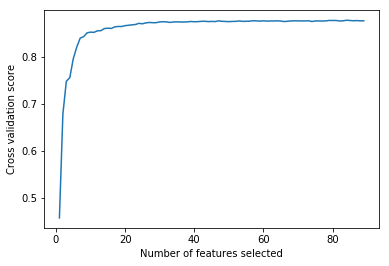

In [13]:
print('Optimal number of features : {}'.format(rfecv.n_features_))
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_);

In [14]:
for col, supp in zip(Xtrain.columns.values, rfecv.get_support()):
    print(col, supp)

italy True
cnorth True
csouth True
north True
sardinia True
sicily True
south True
AUST-XAUS True
BRNN-SUD False
BSP-SLOV True
CNOR-CORS True
CNOR-CSUD True
CNOR-NORD True
CORS-CNOR True
CORS-SARD True
CSUD-CNOR True
CSUD-SARD True
FOGN-SUD True
FRAN-XFRA True
MALT-SICI True
NORD-CNOR True
PRGP-SICI False
ROSN-SICI True
ROSN-SUD True
SARD-CORS True
SARD-CSUD True
SICI-MALT False
SICI-ROSN True
SLOV-BSP True
SUD-CSUD True
XAUS-AUST True
XFRA-FRAN True
hdd_liml True
hdd_lira True
hdd_lirn True
cdd_liml True
cdd_lira True
cdd_lirn True
gas_price True
holiday True
pun_last30 True
mon True
tue True
wed True
thu True
fri True
sat True
sun True
jan True
feb True
mar True
apr True
may True
jun True
jul True
aug True
sep True
oct True
nov True
dec True
h1 True
h2 True
h3 True
h4 False
h5 False
h6 True
h7 True
h8 True
h9 True
h10 True
h11 True
h12 True
h13 True
h14 True
h15 True
h16 True
h17 True
h18 True
h19 True
h20 True
h21 True
h22 True
h23 True
h24 True
pun_hour_last7 True
winter True
eveni

## Random Forest

Transform training set.

In [15]:
Xtrain1 = rfecv.transform(Xtrain)

In [16]:
Xtrain1 = pd.DataFrame(Xtrain1, columns=Xtrain.columns.values[rfecv.get_support()])

In [17]:
forest = RandomForestRegressor(random_state=42)

Parameter tuning.

In [18]:
param_grid = {'n_estimators':np.arange(10, 110, 20),
             'max_features':np.arange(1, Xtrain1.shape[1]+1, 3)}

In [19]:
gs = GridSearchCV(estimator=forest, param_grid=param_grid, n_jobs=2, cv=5, verbose=10)

In [20]:
gs.fit(Xtrain1, ytrain)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   12.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   15.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   20.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   31.5s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   38.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   47.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Do

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_estimators': array([10, 30, 50, 70, 90]), 'max_features': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
       52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [21]:
print(gs.best_score_)
print(gs.best_params_)

0.909549076008
{'max_features': 10, 'n_estimators': 90}


Fit the forest and evaluate performances.

In [22]:
forest.set_params(max_features=10, n_estimators=90)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=90, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [23]:
forest.fit(Xtrain1, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=90, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [24]:
r2_tr, mae_tr, r2_cv, mae_cv, ytr_true, ytr_pred, ycv_true, ycv_pred, imp = evaluate_model(forest, Xtrain1, ytrain)

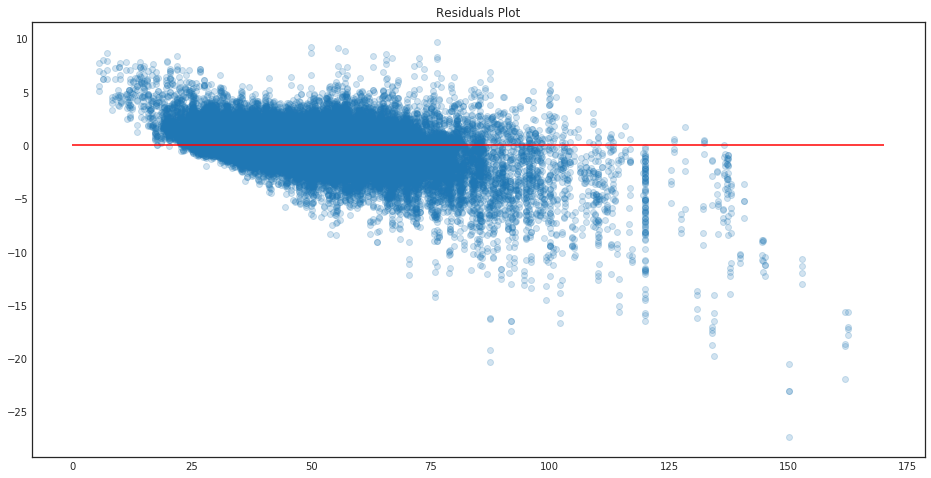

In [25]:
res_tr = residuals_plot(ytr_pred, ytr_true)
# res_tr.savefig('../reports/figures/train_res_forest_all_feat.png');

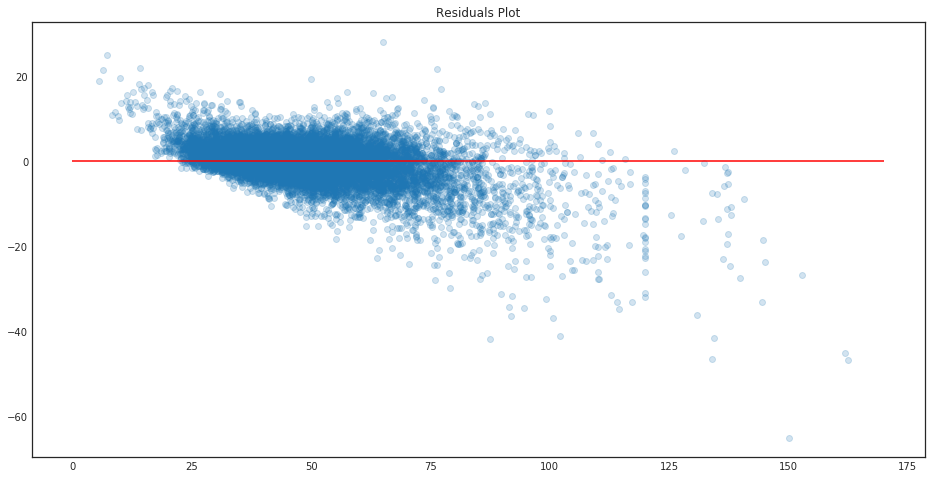

In [26]:
res_cv = residuals_plot(ycv_pred, ycv_true)
# res_cv.savefig('../reports/figures/cv_res_forest_all_feat.png');

In [27]:
print('Train R^2: {:.5f}+-{:.5f}'.format(r2_tr.mean(), r2_tr.std()))
print('Train MAE: {:.5f}+-{:.5f}'.format(mae_tr.mean(), mae_tr.std()))
print('CV R^2: {:.5f}+-{:.5f}'.format(r2_cv.mean(), r2_cv.std()))
print('CV MAE: {:.5f}+-{:.5f}'.format(mae_cv.mean(), mae_cv.std()))

Train R^2: 0.98706+-0.00019
Train MAE: 1.08745+-0.00452
CV R^2: 0.90955+-0.00273
CV MAE: 2.89740+-0.02270


In [28]:
imp.head(10)

,feature,importance
79,pun_hour_last7,0.171572
0,italy,0.0790331
37,pun_last30,0.0767682
1,cnorth,0.0556341
3,north,0.0556131
35,gas_price,0.050614
11,CNOR-NORD,0.0503302
6,south,0.0445422
2,csouth,0.0436492
4,sardinia,0.0389499


I get a MAE of 2.90€, which is quite good.

The residuals plot shows some patterns.

## Random Forest on a Subset of Features

- All the transit limits columns
- Italy energy demand
- HDDs and CDDs for Milan
- Gas price
- Holiday, winter, evening, morning, weekend and July indicators
- Last 30 days PUN moving average
- Last 7 days same-hour PUN moving average

In [29]:
Xtrain_red = Xtrain[['italy', 'AUST-XAUS', 'BRNN-SUD', 'BSP-SLOV', 'CNOR-CORS', 'CNOR-CSUD', 'CNOR-NORD',
                     'CORS-CNOR', 'CORS-SARD', 'CSUD-CNOR', 'CSUD-SARD', 'FOGN-SUD', 'FRAN-XFRA',
                     'MALT-SICI', 'NORD-CNOR', 'PRGP-SICI', 'ROSN-SICI', 'ROSN-SUD', 'SARD-CORS',
                     'SARD-CSUD', 'SICI-MALT', 'SICI-ROSN', 'SLOV-BSP', 'SUD-CSUD', 'XAUS-AUST',
                     'XFRA-FRAN', 'hdd_liml', 'cdd_liml', 'gas_price', 'holiday', 'pun_last30',
                     'jul', 'pun_hour_last7', 'winter', 'evening', 'morning', 'weekend']].copy()

Feature selection using RFE.

In [30]:
# Create the RFE object and compute a cross-validated score.
clf = RandomForestRegressor(random_state=42)
rfecv = RFECV(estimator=clf, step=1)
rfecv.fit(Xtrain_red, ytrain)

RFECV(cv=None,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

Optimal number of features : 31


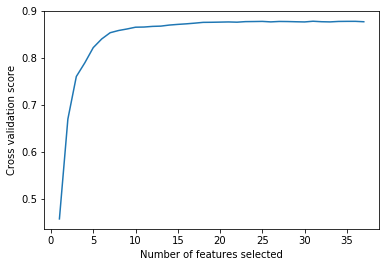

In [31]:
print('Optimal number of features : {}'.format(rfecv.n_features_))
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_);

In [32]:
for col, supp in zip(Xtrain_red.columns.values, rfecv.get_support()):
    print(col, supp)

italy True
AUST-XAUS True
BRNN-SUD False
BSP-SLOV True
CNOR-CORS True
CNOR-CSUD True
CNOR-NORD True
CORS-CNOR False
CORS-SARD True
CSUD-CNOR True
CSUD-SARD True
FOGN-SUD False
FRAN-XFRA True
MALT-SICI False
NORD-CNOR True
PRGP-SICI False
ROSN-SICI True
ROSN-SUD True
SARD-CORS True
SARD-CSUD True
SICI-MALT False
SICI-ROSN True
SLOV-BSP True
SUD-CSUD True
XAUS-AUST True
XFRA-FRAN True
hdd_liml True
cdd_liml True
gas_price True
holiday True
pun_last30 True
jul True
pun_hour_last7 True
winter True
evening True
morning True
weekend True


Transform training data and parameter tuning.

In [33]:
Xtrain2 = rfecv.transform(Xtrain_red)

In [34]:
Xtrain2 = pd.DataFrame(Xtrain2, columns=Xtrain_red.columns.values[rfecv.get_support()])

In [9]:
forest = RandomForestRegressor(random_state=42)

In [36]:
param_grid = {'n_estimators':np.arange(10, 110, 20),
             'max_features':np.arange(1, Xtrain2.shape[1]+1, 3)}

In [37]:
gs = GridSearchCV(estimator=forest, param_grid=param_grid, n_jobs=2, cv=5, verbose=10)

In [38]:
gs.fit(Xtrain2, ytrain)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   18.5s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   24.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   30.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   44.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   54.8s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Do

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_estimators': array([10, 30, 50, 70, 90]), 'max_features': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [39]:
print(gs.best_score_)
print(gs.best_params_)

0.919485486807
{'max_features': 4, 'n_estimators': 90}


Train and evaluate model.

In [40]:
forest.set_params(max_features=4, n_estimators=90)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=90, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [41]:
forest.fit(Xtrain2, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=90, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [42]:
r2_tr, mae_tr, r2_cv, mae_cv, ytr_true, ytr_pred, ycv_true, ycv_pred, imp = evaluate_model(forest, Xtrain2, ytrain)

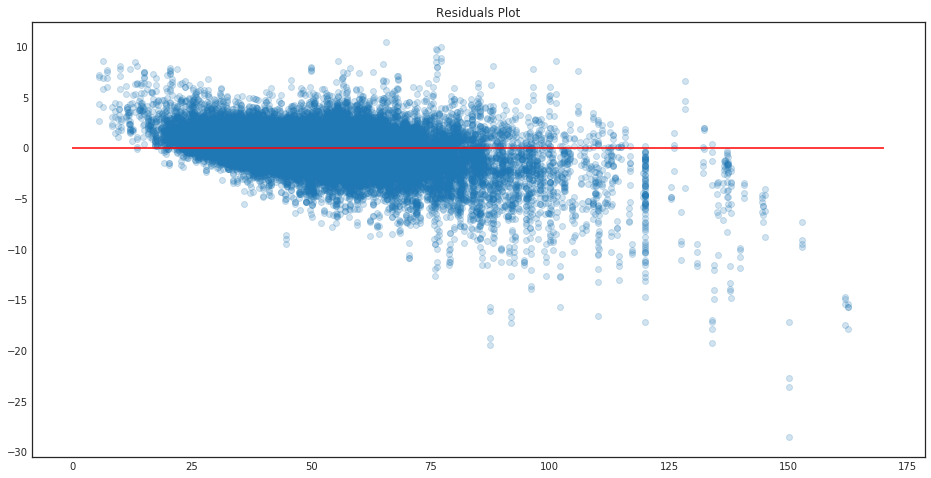

In [43]:
res_tr = residuals_plot(ytr_pred, ytr_true)
# res_tr.savefig('../reports/figures/train_res_forest_subset_feat.png');

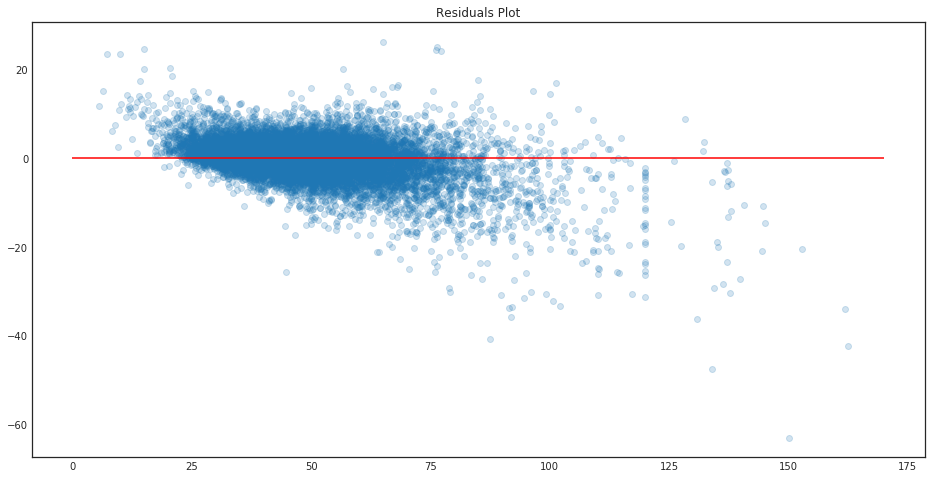

In [44]:
res_cv = residuals_plot(ycv_pred, ycv_true)
# res_cv.savefig('../reports/figures/cv_res_forest_subset_feat.png');

In [45]:
print('Train R^2: {:.5f}+-{:.5f}'.format(r2_tr.mean(), r2_tr.std()))
print('Train MAE: {:.5f}+-{:.5f}'.format(mae_tr.mean(), mae_tr.std()))
print('CV R^2: {:.5f}+-{:.5f}'.format(r2_cv.mean(), r2_cv.std()))
print('CV MAE: {:.5f}+-{:.5f}'.format(mae_cv.mean(), mae_cv.std()))

Train R^2: 0.98870+-0.00016
Train MAE: 1.00894+-0.00169
CV R^2: 0.91949+-0.00246
CV MAE: 2.70100+-0.02428


In [46]:
imp.head(10)

,feature,importance
26,pun_hour_last7,0.228238
0,italy,0.130047
24,pun_last30,0.0995905
5,CNOR-NORD,0.0751957
22,gas_price,0.0682523
4,CNOR-CSUD,0.0489755
21,cdd_liml,0.0358834
19,XFRA-FRAN,0.033357
9,FRAN-XFRA,0.028009
2,BSP-SLOV,0.0252446


The MAE is better than before (2.70€), residuals are still showing patterns.

## SVM on a Subset of Features

Parameter tuning.

In [47]:
svm = SVR()

In [48]:
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'gamma':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [49]:
gs = GridSearchCV(estimator=svm, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10)

In [50]:
gs.fit(Xtrain2, ytrain)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 52.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 61.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 76.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 94.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 121.8min
[Parall

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [51]:
print(gs.best_score_)
print(gs.best_params_)

0.0453872243715
{'C': 100, 'gamma': 0.001}


Fit and evaluate.

In [52]:
svm.set_params(C=100, gamma=0.001)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [53]:
svm.fit(Xtrain2, ytrain)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [54]:
r2_tr, mae_tr, r2_cv, mae_cv, ytr_true, ytr_pred, ycv_true, ycv_pred, imp = evaluate_model(svm, Xtrain2, ytrain, importances=False)

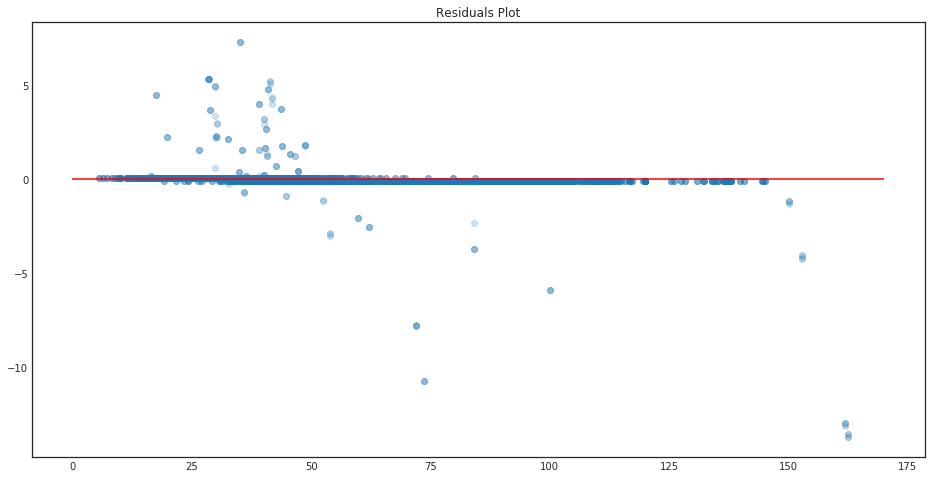

In [55]:
res_tr = residuals_plot(ytr_pred, ytr_true)
# res_tr.savefig('../reports/figures/train_res_svm.png');

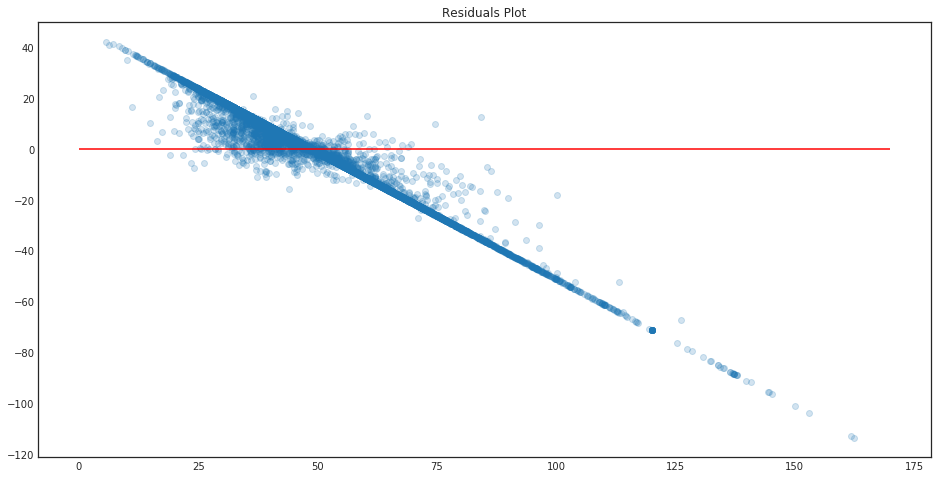

In [56]:
res_cv = residuals_plot(ycv_pred, ycv_true)
# res_cv.savefig('../reports/figures/cv_res_svm.png');

In [57]:
print('Train R^2: {:.5f}+-{:.5f}'.format(r2_tr.mean(), r2_tr.std()))
print('Train MAE: {:.5f}+-{:.5f}'.format(mae_tr.mean(), mae_tr.std()))
print('CV R^2: {:.5f}+-{:.5f}'.format(r2_cv.mean(), r2_cv.std()))
print('CV MAE: {:.5f}+-{:.5f}'.format(mae_cv.mean(), mae_cv.std()))

Train R^2: 0.99975+-0.00004
Train MAE: 0.10616+-0.00084
CV R^2: 0.04539+-0.00590
CV MAE: 10.22980+-0.20272


It seems that SVM is grossly overfitting the data.

## Random Forest Boosted on a Subset of Features

Boosting parameter tuning (I'm using the best forest from above).

In [58]:
forest = RandomForestRegressor(max_features=4, n_estimators=70, random_state=42)

In [59]:
ada = AdaBoostRegressor(base_estimator=forest)

In [60]:
param_grid = {'n_estimators':np.arange(10, 110, 20),
             'learning_rate':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [61]:
gs = GridSearchCV(estimator=ada, param_grid=param_grid, n_jobs=2, cv=5, verbose=10)

In [62]:
gs.fit(Xtrain2, ytrain)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   31.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 12.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 26.5min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 35.6min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 43.3min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 60.2min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 72.4min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 87.8min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 104.7min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 119.6min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 131.5min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 134.1min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 134.6min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 135.1min
[Parallel(n_jobs=2

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_lea...tart=False),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_estimators': array([10, 30, 50, 70, 90]), 'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [63]:
print(gs.best_score_)
print(gs.best_params_)

0.929331273217
{'learning_rate': 1, 'n_estimators': 90}


Fit and evaluate.

In [64]:
ada.set_params(learning_rate=1, n_estimators=90)

AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=70, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
         learning_rate=1, loss='linear', n_estimators=90,
         random_state=None)

In [65]:
ada.fit(Xtrain2, ytrain)

AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=70, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
         learning_rate=1, loss='linear', n_estimators=90,
         random_state=None)

In [66]:
r2_tr, mae_tr, r2_cv, mae_cv, ytr_true, ytr_pred, ycv_true, ycv_pred, imp = evaluate_model(ada, Xtrain2, ytrain, importances=False)

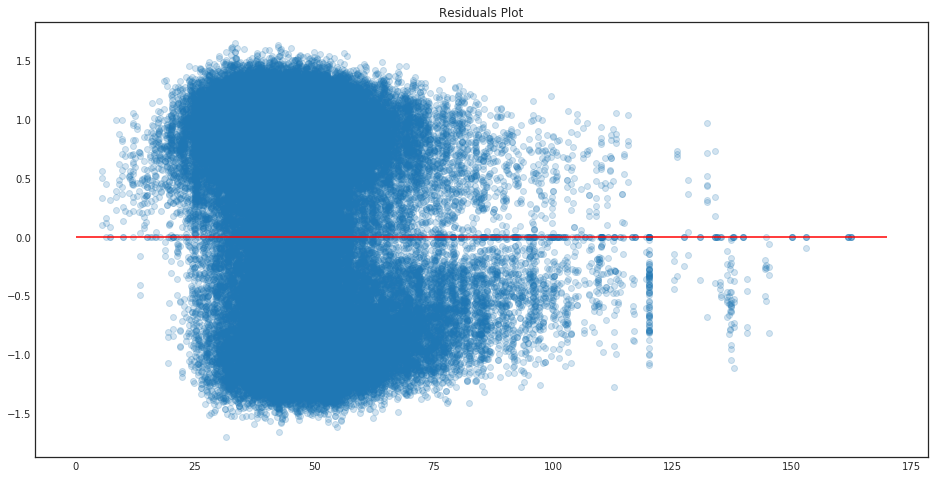

In [67]:
res_tr = residuals_plot(ytr_pred, ytr_true)
# res_tr.savefig('../reports/figures/train_res_ada.png');

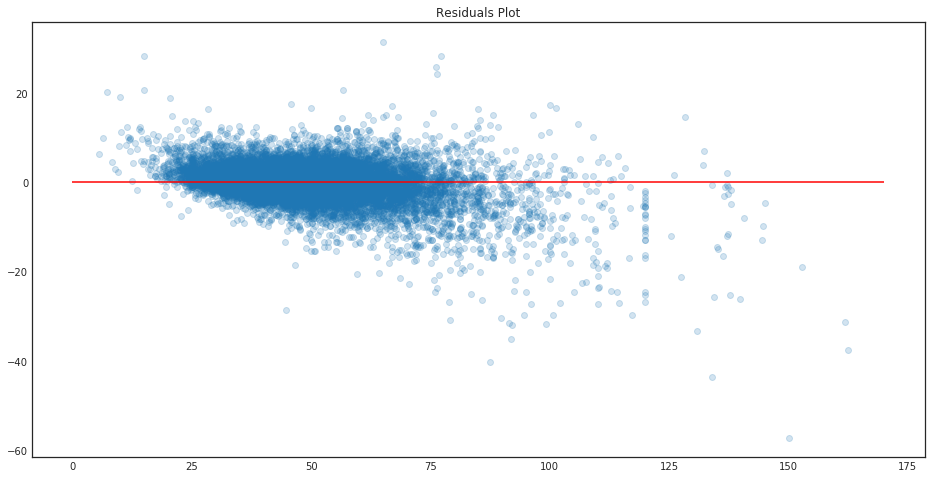

In [68]:
res_cv = residuals_plot(ycv_pred, ycv_true)
# res_cv.savefig('../reports/figures/cv_res_ada.png');

In [69]:
print('Train R^2: {:.5f}+-{:.5f}'.format(r2_tr.mean(), r2_tr.std()))
print('Train MAE: {:.5f}+-{:.5f}'.format(mae_tr.mean(), mae_tr.std()))
print('CV R^2: {:.5f}+-{:.5f}'.format(r2_cv.mean(), r2_cv.std()))
print('CV MAE: {:.5f}+-{:.5f}'.format(mae_cv.mean(), mae_cv.std()))

Train R^2: 0.99629+-0.00003
Train MAE: 0.80498+-0.00312
CV R^2: 0.92939+-0.00272
CV MAE: 2.58345+-0.02034


I'm overfitting but so far this is the best model.

## Random Forest with More Data

Now I'm trying to discard the variables for which I don't have data for 2014 and see if, choosing the same subset as before, more data is better.

In [70]:
energy_full.drop(['AUST-XAUS', 'FRAN-XFRA', 'MALT-SICI', 'SICI-MALT', 'XAUS-AUST', 'XFRA-FRAN', 'hdd_liml', 'hdd_lira', 'hdd_lirn', 'cdd_liml', 'cdd_lira', 'cdd_lirn'], axis=1, inplace=True)

In [71]:
energy_full.dropna(inplace=True)

In [74]:
Xtrain_full, Xtest_full, ytrain_full, ytest_full = train_test_split(energy_full.drop(['pun'], axis=1), energy_full['pun'], test_size=0.2, random_state=30)

In [75]:
Xtrain_full.drop(['date', 'hour'], axis=1, inplace=True)

In [76]:
Xtrain_full_red = Xtrain_full[['italy', 'BRNN-SUD', 'BSP-SLOV', 'CNOR-CORS', 'CNOR-CSUD', 'CNOR-NORD',
                             'CORS-CNOR', 'CORS-SARD', 'CSUD-CNOR', 'CSUD-SARD', 'FOGN-SUD',
                             'NORD-CNOR', 'PRGP-SICI', 'ROSN-SICI', 'ROSN-SUD', 'SARD-CORS',
                             'SARD-CSUD', 'SICI-ROSN', 'SLOV-BSP', 'SUD-CSUD',
                             'gas_price', 'holiday', 'pun_last30',
                             'jul', 'pun_hour_last7', 'winter', 'weekend']]

Fit and evaluate the best forest model from before to get an idea of the performances.

In [77]:
forest.fit(Xtrain_full, ytrain_full)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=70, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [78]:
r2_tr, mae_tr, r2_cv, mae_cv, ytr_true, ytr_pred, ycv_true, ycv_pred, imp = evaluate_model(forest, Xtrain_full, ytrain_full)

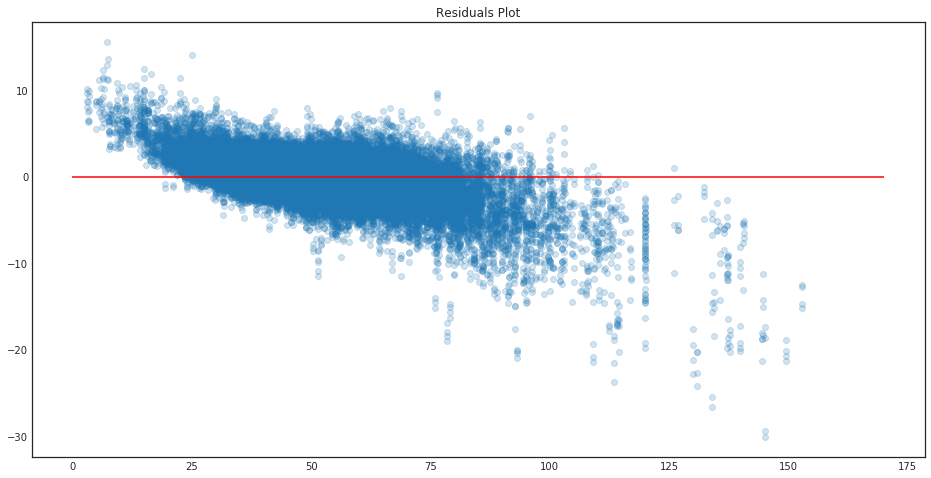

In [79]:
res_tr = residuals_plot(ytr_pred, ytr_true)
# res_tr.savefig('../reports/figures/train_res_forest_full.png');

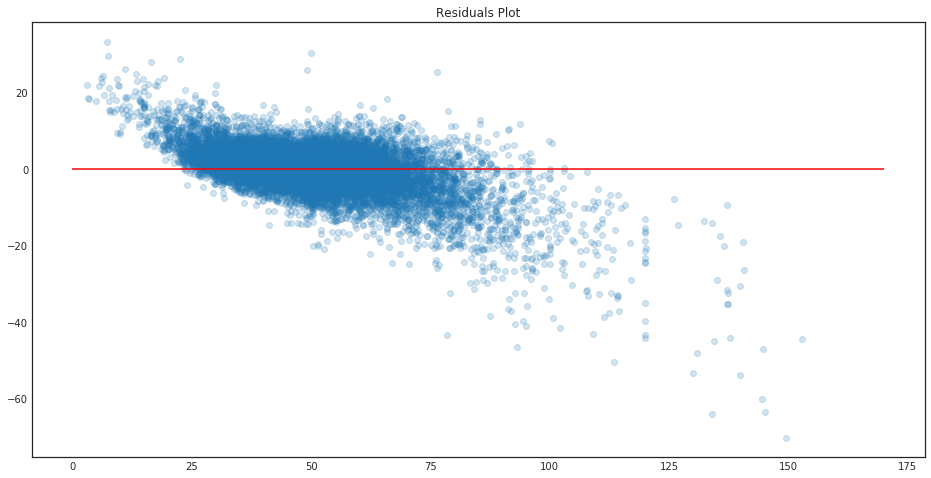

In [80]:
res_cv = residuals_plot(ycv_pred, ycv_true)
# res_cv.savefig('../reports/figures/cv_res_forest_full.png');

In [81]:
print('Train R^2: {:.5f}+-{:.5f}'.format(r2_tr.mean(), r2_tr.std()))
print('Train MAE: {:.5f}+-{:.5f}'.format(mae_tr.mean(), mae_tr.std()))
print('CV R^2: {:.5f}+-{:.5f}'.format(r2_cv.mean(), r2_cv.std()))
print('CV MAE: {:.5f}+-{:.5f}'.format(mae_cv.mean(), mae_cv.std()))

Train R^2: 0.97912+-0.00024
Train MAE: 1.41514+-0.00837
CV R^2: 0.85280+-0.00395
CV MAE: 3.76845+-0.05636


The MAE is way worst than the previous ones, I don't think that tuning could improve it enough to compete with the other models. Evidently the variables I dropped add more value to the model than having more data to train it.

## One Random Forest per Hour

Lastly, I'll try tuning and training one model for each hour of the day, always using the same subset of variables.

In [82]:
hour_cols = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 
            'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']

In [83]:
Xtrain_red2 = Xtrain[['italy', 'AUST-XAUS', 'BRNN-SUD', 'BSP-SLOV', 'CNOR-CORS', 'CNOR-CSUD', 'CNOR-NORD',
                     'CORS-CNOR', 'CORS-SARD', 'CSUD-CNOR', 'CSUD-SARD', 'FOGN-SUD', 'FRAN-XFRA',
                     'MALT-SICI', 'NORD-CNOR', 'PRGP-SICI', 'ROSN-SICI', 'ROSN-SUD', 'SARD-CORS',
                     'SARD-CSUD', 'SICI-MALT', 'SICI-ROSN', 'SLOV-BSP', 'SUD-CSUD', 'XAUS-AUST',
                     'XFRA-FRAN', 'hdd_liml', 'cdd_liml', 'gas_price', 'holiday', 'pun_last30',
                     'jul', 'pun_hour_last7', 'winter', 'weekend'] + hour_cols].copy()

Initialize each model.

In [84]:
forest_h1 = RandomForestRegressor(random_state=25)
forest_h2 = RandomForestRegressor(random_state=25)
forest_h3 = RandomForestRegressor(random_state=25)
forest_h4 = RandomForestRegressor(random_state=25)
forest_h5 = RandomForestRegressor(random_state=25)
forest_h6 = RandomForestRegressor(random_state=25)
forest_h7 = RandomForestRegressor(random_state=25)
forest_h8 = RandomForestRegressor(random_state=25)
forest_h9 = RandomForestRegressor(random_state=25)
forest_h10 = RandomForestRegressor(random_state=25)
forest_h11 = RandomForestRegressor(random_state=25)
forest_h12 = RandomForestRegressor(random_state=25)
forest_h13 = RandomForestRegressor(random_state=25)
forest_h14 = RandomForestRegressor(random_state=25)
forest_h15 = RandomForestRegressor(random_state=25)
forest_h16 = RandomForestRegressor(random_state=25)
forest_h17 = RandomForestRegressor(random_state=25)
forest_h18 = RandomForestRegressor(random_state=25)
forest_h19 = RandomForestRegressor(random_state=25)
forest_h20 = RandomForestRegressor(random_state=25)
forest_h21 = RandomForestRegressor(random_state=25)
forest_h22 = RandomForestRegressor(random_state=25)
forest_h23 = RandomForestRegressor(random_state=25)
forest_h24 = RandomForestRegressor(random_state=25)

In [85]:
models = [forest_h1, forest_h2, forest_h3, forest_h4, forest_h5, forest_h6, forest_h7, forest_h8, forest_h9, forest_h10, forest_h11, forest_h12, forest_h13, forest_h14, forest_h15, forest_h16, forest_h17, forest_h18, forest_h19, forest_h20, forest_h21, forest_h22, forest_h23, forest_h24]

Tune each model.

In [86]:
param_grid = {'n_estimators':np.arange(10, 110, 20),
             'max_features':np.arange(1, Xtrain_red2.drop(hour_cols, axis=1).shape[1]+1, 3)}

for hour, model in zip(hour_cols, models):
    print(hour)
    gs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=5, verbose=10)
    gs.fit(Xtrain_red2.loc[Xtrain_red2[hour]==1].drop(hour_cols, axis=1), ytrain.loc[Xtrain_red2[hour]==1])
    print(gs.best_score_)
    print(gs.best_params_)

h1
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    7.6s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    8.9s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   11.8s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   13.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   15.9s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   17.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   20.0s
[Parallel(n_jobs=2)]: Do

0.773189264307
{'max_features': 10, 'n_estimators': 70}
h2
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   12.9s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   15.3s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   16.9s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   19.1s
[Parallel(n_jobs=2)]: Do

0.763855277284
{'max_features': 13, 'n_estimators': 90}
h3
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    9.6s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   11.1s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   12.7s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   15.3s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   17.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   19.5s
[Parallel(n_jobs=2)]: Do

0.728667445606
{'max_features': 10, 'n_estimators': 30}
h4
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   10.4s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   12.0s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   13.6s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   16.3s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   18.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   20.4s
[Parallel(n_jobs=2)]: Do

0.743849052122
{'max_features': 7, 'n_estimators': 70}
h5
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    9.6s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   12.7s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   15.1s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   16.7s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   19.0s
[Parallel(n_jobs=2)]: Do

0.707430632054
{'max_features': 13, 'n_estimators': 70}
h6
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    7.1s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    9.6s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   12.6s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   15.0s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   16.8s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   19.2s
[Parallel(n_jobs=2)]: Do

0.766276745534
{'max_features': 13, 'n_estimators': 90}
h7
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    9.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   12.6s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   14.9s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   16.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   18.9s
[Parallel(n_jobs=2)]: Do

0.798141326532
{'max_features': 7, 'n_estimators': 90}
h8
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    7.5s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    8.8s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   13.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   16.1s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   17.8s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   20.4s
[Parallel(n_jobs=2)]: Do

0.826641111827
{'max_features': 7, 'n_estimators': 50}
h9
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    8.4s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    9.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   11.1s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   12.7s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   15.1s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   16.8s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   19.1s
[Parallel(n_jobs=2)]: Do

0.818614385004
{'max_features': 4, 'n_estimators': 50}
h10
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    9.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   12.9s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   15.5s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   17.3s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   19.7s
[Parallel(n_jobs=2)]: Do

0.799156983658
{'max_features': 13, 'n_estimators': 90}
h11
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    7.1s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   14.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   17.6s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   19.9s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   23.2s
[Parallel(n_jobs=2)]: Do

0.77884386773
{'max_features': 13, 'n_estimators': 90}
h12
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    9.4s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   10.8s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   12.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   14.6s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   16.7s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   20.2s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   22.1s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   24.9s
[Parallel(n_jobs=2)]: Do

0.744570266666
{'max_features': 13, 'n_estimators': 90}
h13
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    7.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.2s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    9.2s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   12.4s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   14.3s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   16.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   19.7s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   22.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   24.9s
[Parallel(n_jobs=2)]: Do

0.781223779446
{'max_features': 7, 'n_estimators': 70}
h14
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   12.7s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   14.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   16.8s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   19.2s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   23.3s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   25.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   29.1s
[Parallel(n_jobs=2)]: Do

0.782240412115
{'max_features': 16, 'n_estimators': 50}
h15
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   13.0s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   15.0s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   17.2s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   19.6s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   23.6s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   26.2s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   29.9s
[Parallel(n_jobs=2)]: Do

0.790245588864
{'max_features': 4, 'n_estimators': 90}
h16
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    5.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    7.6s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    8.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.8s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   12.1s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   14.0s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   16.0s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   18.5s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   20.9s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   24.5s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   26.8s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   30.0s
[Parallel(n_jobs=2)]: Do

0.796003440596
{'max_features': 7, 'n_estimators': 90}
h17
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    9.7s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   13.1s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   15.2s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   17.5s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   21.1s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   23.4s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   26.6s
[Parallel(n_jobs=2)]: Do

0.797450646991
{'max_features': 4, 'n_estimators': 90}
h18
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   13.1s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   15.3s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   17.5s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   20.8s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   23.2s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   26.3s
[Parallel(n_jobs=2)]: Do

0.848183911745
{'max_features': 4, 'n_estimators': 50}
h19
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    5.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   13.2s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   15.2s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   17.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   20.9s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   23.3s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   26.6s
[Parallel(n_jobs=2)]: Do

0.789408317079
{'max_features': 4, 'n_estimators': 90}
h20
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   10.5s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   12.3s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   14.1s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   16.1s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   18.2s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   21.7s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   24.2s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   27.7s
[Parallel(n_jobs=2)]: Do

0.746624924067
{'max_features': 4, 'n_estimators': 90}
h21
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   13.3s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   15.3s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   17.7s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   20.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   23.5s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   26.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   29.6s
[Parallel(n_jobs=2)]: Do

0.646215792653
{'max_features': 4, 'n_estimators': 70}
h22
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.0s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.5s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   10.6s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   12.4s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   14.5s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   16.6s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   19.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   22.9s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   25.2s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   28.8s
[Parallel(n_jobs=2)]: Do

0.695622588098
{'max_features': 16, 'n_estimators': 90}
h23
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   13.0s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   15.0s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   17.3s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   19.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   23.3s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   25.7s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   29.2s
[Parallel(n_jobs=2)]: Do

0.798339396193
{'max_features': 13, 'n_estimators': 70}
h24
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.6s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   10.8s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   12.4s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   14.3s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   16.2s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   18.6s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   22.4s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   24.7s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   28.2s
[Parallel(n_jobs=2)]: Do

0.812609765739
{'max_features': 10, 'n_estimators': 90}


By quickly looking at tuning scores I can see that this model are performing worst than the one with all the hours together; this may be due to

1. The variability of the hourly data is less than that of the whole dataset and this is hurting my model and
2. I have 1/24 of the data to train on, again making the model less precise.

## Conclusions

Boosted random forest is the best model among the ones I tried, even if it seems to overfit a bit the training set.

I have seen that discarding variables in order to get more data isn't useful, probably because the added value of some of the dropped columns is high (I think the weather data is mainly responsible for this) - it could still be useful though to get more training data if I wouldn't have to drop variables.

I have also concluded that trying to predict the PUN for each hour separately produces worst results than training on all the data at once.

Now let's look at the residuals plot for this model trying to highlight different variables' values:

In [87]:
ypred = ada.predict(Xtrain2)

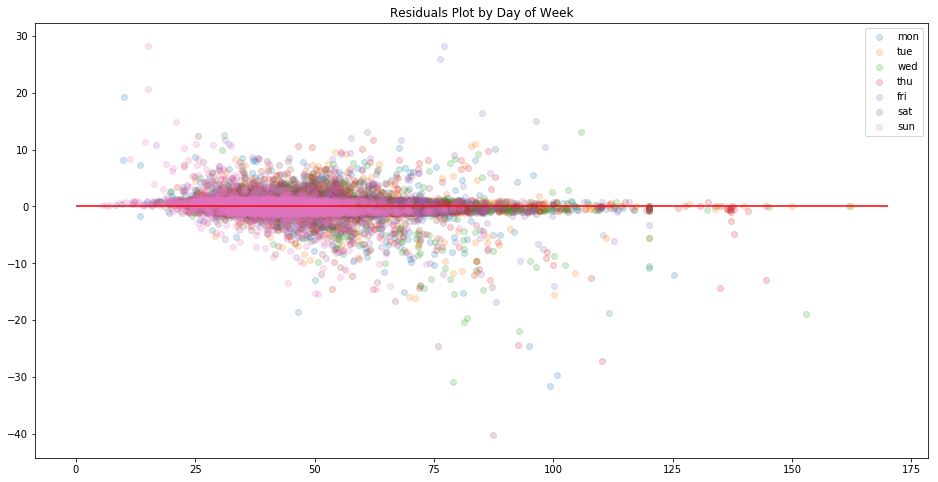

In [88]:
fig, ax = plt.subplots(figsize=(16, 8))
for col in ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']:
    ax.scatter(ytrain[Xtrain[col]==1], ypred[Xtrain[col]==1] - ytrain[Xtrain[col]==1], alpha=0.2, label=col)
    
ax.hlines(y=0, xmin=0, xmax=170, colors='r')
ax.set_title('Residuals Plot by Day of Week')
ax.legend();
# fig.savefig('../reports/figures/res_forest_by_weekday.png');

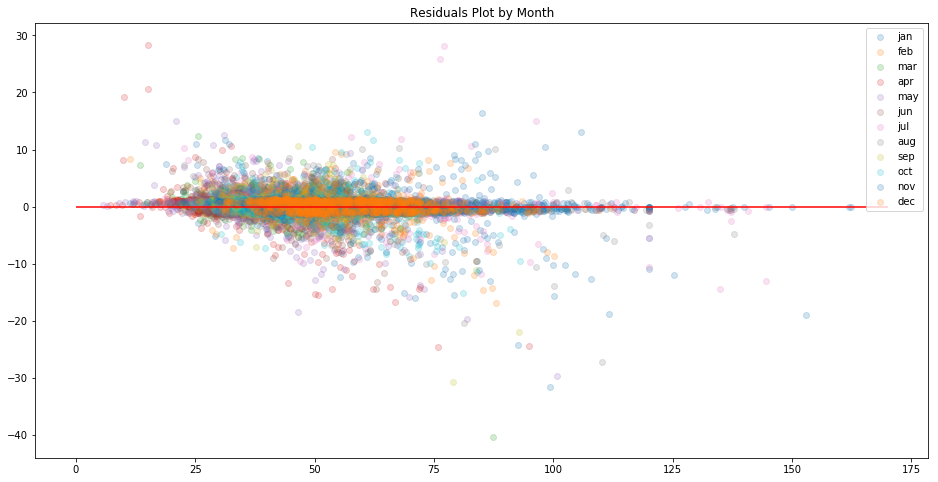

In [89]:
fig, ax = plt.subplots(figsize=(16, 8))
for col in ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']:
    ax.scatter(ytrain[Xtrain[col]==1], ypred[Xtrain[col]==1] - ytrain[Xtrain[col]==1], alpha=0.2, label=col)
    
ax.hlines(y=0, xmin=0, xmax=170, colors='r')
ax.set_title('Residuals Plot by Month')
ax.legend();
# fig.savefig('../reports/figures/res_forest_by_month.png');

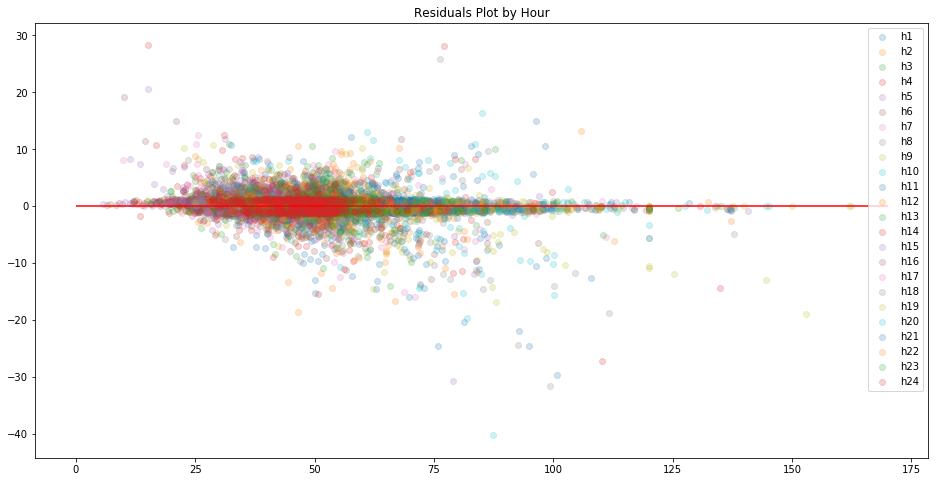

In [90]:
fig, ax = plt.subplots(figsize=(16, 8))
for col in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']:
    ax.scatter(ytrain[Xtrain[col]==1], ypred[Xtrain[col]==1] - ytrain[Xtrain[col]==1], alpha=0.2, label=col)
    
ax.hlines(y=0, xmin=0, xmax=170, colors='r')
ax.set_title('Residuals Plot by Hour')
ax.legend();
# fig.savefig('../reports/figures/res_forest_by_hour.png');

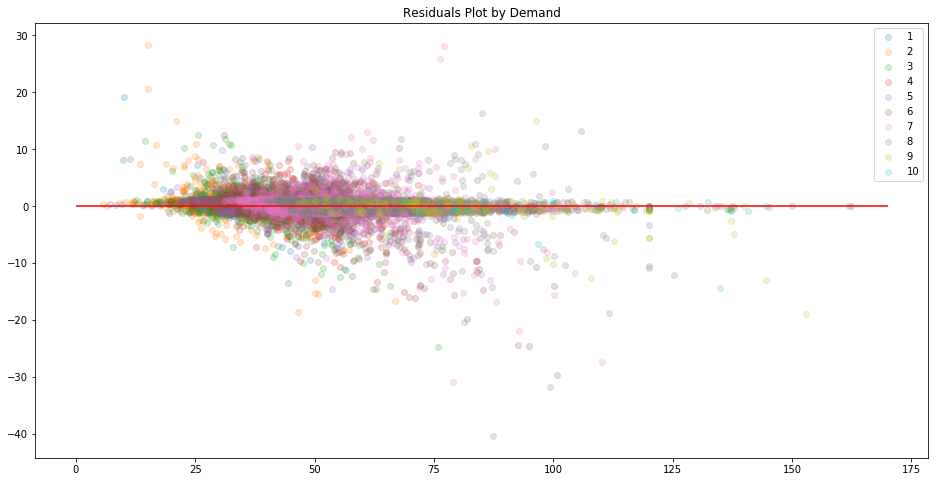

In [91]:
fig, ax = plt.subplots(figsize=(16, 8))
bins, edges = np.histogram(Xtrain['italy'])
for i in np.arange(1, len(edges)):
    # print(len(ytrain[(Xtrain['italy']<=edges[i]) & (Xtrain['italy']>edges[i-1])]))
    ax.scatter(ytrain[(Xtrain['italy']<=edges[i]) & (Xtrain['italy']>edges[i-1])],
               ypred[(Xtrain['italy']<=edges[i]) & (Xtrain['italy']>edges[i-1])] - ytrain[(Xtrain['italy']<=edges[i]) & (Xtrain['italy']>edges[i-1])],
               alpha=0.2, label=str(i))
    i += 1

ax.hlines(y=0, xmin=0, xmax=170, colors='r')
ax.set_title('Residuals Plot by Demand')
ax.legend();
# fig.savefig('../reports/figures/res_forest_by_demand.png');

The residuals seems to show the same pattern across all variables' values.

Let's also look at learning curves:

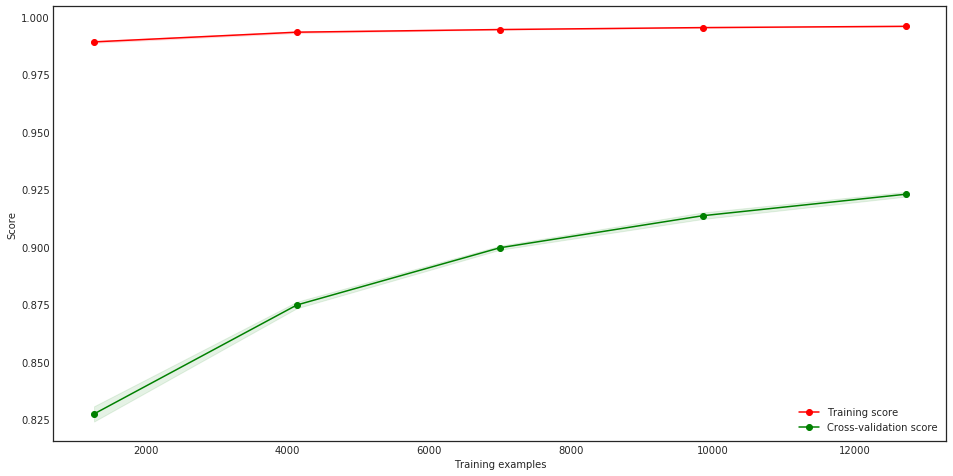

In [94]:
lp = learning_plot(ada, Xtrain2, ytrain)
# lp.savefig('../reports/figures/learning_curves.png');

Finally, let's see how the boosted random forest fares on test data:

In [95]:
Xtest2 = Xtest[['italy', 'AUST-XAUS', 'BRNN-SUD', 'BSP-SLOV', 'CNOR-CORS', 'CNOR-CSUD', 'CNOR-NORD',
                 'CORS-CNOR', 'CORS-SARD', 'CSUD-CNOR', 'CSUD-SARD', 'FOGN-SUD', 'FRAN-XFRA',
                 'MALT-SICI', 'NORD-CNOR', 'PRGP-SICI', 'ROSN-SICI', 'ROSN-SUD', 'SARD-CORS',
                 'SARD-CSUD', 'SICI-MALT', 'SICI-ROSN', 'SLOV-BSP', 'SUD-CSUD', 'XAUS-AUST',
                 'XFRA-FRAN', 'hdd_liml', 'cdd_liml', 'gas_price', 'holiday', 'pun_last30',
                 'jul', 'pun_hour_last7', 'winter', 'evening', 'morning', 'weekend']].copy()

In [96]:
Xtest2 = rfecv.transform(Xtest2)

In [97]:
print(ada.score(Xtest2, ytest))
print(mean_absolute_error(ytest, ada.predict(Xtest2)))

0.934843434596
2.56013210774


I actually get a better MAE than on the validation set: 2.56€.